In [ ]:
%load_ext watermark
%watermark  -d -u -a 'Andreas Mueller, Kyle Kastner, Sebastian Raschka' -v -p numpy,scipy,matplotlib,scikit-learn

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# SciPy 2016 Scikit-learn Tutorial

# Parameter selection, Validation, and Testing

Most models have parameters that influence how complex a model they can learn. Remember using `KNeighborsRegressor`.
If we change the number of neighbors we consider, we get a smoother and smoother prediction:

<img src="figures/plot_kneigbors_regularization.png" width="100%">

In the above figure, we see fits for three different values of ``n_neighbors``.
For ``n_neighbors=2``, the data is overfit, the model is too flexible and can adjust too much to the noise in the training data. For ``n_neighbors=20``, the model is not flexible enough, and can not model the variation in the data appropriately.

In the middle, for ``n_neighbors = 5``, we have found a good mid-point. It fits
the data fairly well, and does not suffer from the overfit or underfit
problems seen in the figures on either side. What we would like is a
way to quantitatively identify overfit and underfit, and optimize the
hyperparameters (in this case, the polynomial degree d) in order to
determine the best algorithm.

We trade off remembering too much about the particularities and noise of the training data vs. not modeling enough of the variability. This is a trade-off that needs to be made in basically every machine learning application and is a central concept, called bias-variance-tradeoff or "overfitting vs underfitting".

<img src="figures/overfitting_underfitting_cartoon.svg" width="100%">


## Hyperparameters, Over-fitting, and Under-fitting

Unfortunately, there is no general rule how to find the sweet spot, and so machine learning practitioners have to find the best trade-off of model-complexity and generalization by trying several hyperparameter settings. Hyperparameters are the internal knobs or tuning parameters of a machine learning algorithm (in contrast to model parameters that the algorithm learns from the training data -- for example, the weight coefficients of a linear regression model); the number of *k* in K-nearest neighbors is such a hyperparameter.

Most commonly this "hyperparameter tuning" is done using a brute force search, for example over multiple values of ``n_neighbors``:


In [161]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
# generate toy dataset:
x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
# create 2D matrix X with shape = (n_samples, n_features) from 1D matrix X
X = x[:, np.newaxis]

cv = KFold(shuffle=True)

# for each parameter setting do cross-validation:
for n_neighbors in [1, 3, 5, 10, 20]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X, y, cv=cv)
    print("n_neighbors: %d, average score: %f" % (n_neighbors, np.mean(scores)))

n_neighbors: 1, average score: 0.538380
n_neighbors: 3, average score: 0.740929
n_neighbors: 5, average score: 0.757285
n_neighbors: 10, average score: 0.711777
n_neighbors: 20, average score: 0.608429


There is a function in scikit-learn, called ``validation_plot`` to reproduce the cartoon figure above. It plots one parameter, such as the number of neighbors, against training and validation error (using cross-validation):

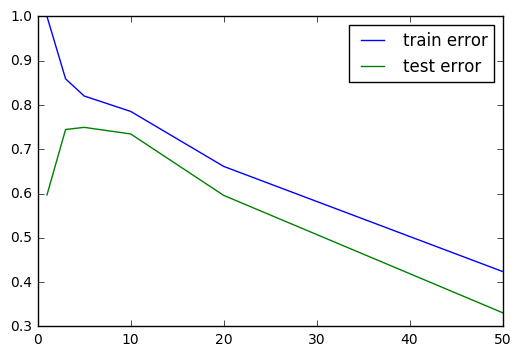

In [116]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 3, 5, 10, 20, 50]

# return 2D error matrix with shape = (n_param_scan, n_cv_scan)
train_errors, test_errors = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)

# plot mean error for each param_scan (average over n_cv_scan)
plt.plot(n_neighbors, train_errors.mean(axis=1), label="train error")
plt.plot(n_neighbors, test_errors.mean(axis=1), label="test error")
plt.legend(loc="best")

Note that many neighbors mean a "smooth" or "simple" model, so the plot is the mirror image of the diagram above.

If multiple parameters are important, like the parameters ``C`` and ``gamma`` in an ``SVM`` (more about that later), all possible combinations are tried:

In [117]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# each parameter setting do cross-validation:
for C in [0.001, 0.01, 0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1, 1]:
        scores = cross_val_score(SVR(C=C, gamma=gamma), X, y, cv=cv)
        print("C: %f, gamma: %f, average score: %f" % (C, gamma, np.mean(scores)))

C: 0.001000, gamma: 0.001000, average score: -0.042946
C: 0.001000, gamma: 0.010000, average score: -0.008101
C: 0.001000, gamma: 0.100000, average score: -0.027729
C: 0.001000, gamma: 1.000000, average score: -0.076927
C: 0.010000, gamma: 0.001000, average score: -0.037444
C: 0.010000, gamma: 0.010000, average score: -0.002649
C: 0.010000, gamma: 0.100000, average score: 0.087607
C: 0.010000, gamma: 1.000000, average score: 0.085148
C: 0.100000, gamma: 0.001000, average score: -0.014532
C: 0.100000, gamma: 0.010000, average score: 0.149221
C: 0.100000, gamma: 0.100000, average score: 0.524063
C: 0.100000, gamma: 1.000000, average score: 0.406942
C: 1.000000, gamma: 0.001000, average score: 0.161081
C: 1.000000, gamma: 0.010000, average score: 0.571559
C: 1.000000, gamma: 0.100000, average score: 0.676671
C: 1.000000, gamma: 1.000000, average score: 0.696725
C: 10.000000, gamma: 0.001000, average score: 0.590316
C: 10.000000, gamma: 0.010000, average score: 0.552329
C: 10.000000, gamma

As this is such a very common pattern, there is a built-in class for this in scikit-learn, ``GridSearchCV``. ``GridSearchCV`` takes a dictionary that describes the parameters that should be tried and a model to train.

The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [190]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=3)

One of the great things about GridSearchCV is that it is a *meta-estimator*. It takes an estimator like SVR above, and creates a new estimator, that behaves exactly the same - in this case, like a regressor.
So we can call ``fit`` on it, to train it:

In [198]:
grid.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............ C=0.001, gamma=0.001, score=-0.087665, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............ C=0.001, gamma=0.001, score=-0.028236, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............ C=0.001, gamma=0.001, score=-0.831720, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............ C=0.001, gamma=0.001, score=-0.029885, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............ C=0.001, gamma=0.001, score=-0.109854, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............ C=0.001, gamma=0.001, score=-0.021072, total=   0.0s
[CV] C=0.001, gamma=0.001 ............................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.001, score=-0.236281, total=   0.0s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.001, score=-0.001178, total=   0.0s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.001, score=-0.007743, total=   0.0s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.001, score=-0.003996, total=   0.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.01, score=-0.055765, total=   0.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.001102, total=   0.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.01, score=-0.745839, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.4s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

What ``fit`` does is a bit more involved then what we did above. First, it runs the same loop with cross-validation, to find the best parameter combination.
Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

Then, as with all models, we can use ``predict`` or ``score``:


In [200]:
grid.predict(X)

array([-1.79762875, -1.74054091, -1.71412904, -1.72272347, -1.76880247,
       -1.8527208 , -1.97255382, -2.12407501, -2.30087676, -2.49463429,
       -2.695503  , -2.89262935, -3.07474705, -3.23082299, -3.35071314,
       -3.42578612, -3.44947391, -3.41771237, -3.32924127, -3.18574205,
       -2.9918017 , -2.75470244, -2.48404785, -2.19124658, -1.88888388,
       -1.59001819, -1.30744475, -1.05297034, -0.8367425 , -0.66667333,
       -0.54799235, -0.4829551 , -0.4707249 , -0.50743515, -0.58642852,
       -0.69865919, -0.83323456, -0.97806438, -1.12057877, -1.24847261,
       -1.35043139, -1.41679516, -1.44012026, -1.41560488, -1.3413525 ,
       -1.21845724, -1.05090633, -0.84530623, -0.61045003, -0.35675398,
       -0.09559933,  0.16137852,  0.40300817,  0.61926205,  0.80185531,
        0.94472644,  1.04437082,  1.10000798,  1.11357463,  1.08954695,
        1.03460678,  0.95717608,  0.86685224,  0.7737823 ,  0.68801751,
        0.61888941,  0.57444669,  0.56098656,  0.58270777,  0.64

You can inspect the best parameters found by ``GridSearchCV`` in the ``best_params_`` attribute, and the best score in the ``best_score_`` attribute:

In [201]:
print(grid.best_score_)

0.702214304117


In [202]:
print(grid.best_estimator_)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [203]:
print(grid.best_params_)

{'C': 10, 'gamma': 1}


There is a problem with using this score for evaluation, however. You might be making what is called a multiple hypothesis testing error. If you try very many parameter settings, some of them will work better just by chance, and the score that you obtained might not reflect how your model would perform on new unseen data.
Therefore, it is good to split off a separate test-set before performing grid-search. This pattern can be seen as a training-validation-test split, and is common in machine learning:

<img src="figures/grid_search_cross_validation.svg" width="100%">

We can do this very easily by splitting of some test data using ``train_test_split``, training ``GridSearchCV`` on the training set, and applying the ``score`` method to the test set:

In [222]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.7262035177984737

We can also look at the parameters that were selected:

In [220]:
grid.best_params_

{'C': 10, 'gamma': 1}

Some practitioners go for an easier scheme, splitting the data simply into three parts, training, validation and testing. This is a possible alternative if your training set is very large, or it is infeasible to train many models using cross-validation because training a model takes very long.
You can do this with scikit-learn for example by splitting of a test-set and then applying GridSearchCV with ShuffleSplit cross-validation with a single iteration:

<img src="figures/train_validation_test2.svg" width="100%">

In [236]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
single_split_cv = ShuffleSplit(n_splits=1)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ............ C=0.001, gamma=0.001, score=-0.114816, total=   0.0s
[CV] C=0.001, gamma=0.01 .............................................
[CV] ............. C=0.001, gamma=0.01, score=-0.114657, total=   0.0s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .............. C=0.001, gamma=0.1, score=-0.112392, total=   0.0s
[CV] C=0.001, gamma=1 ................................................
[CV] ................ C=0.001, gamma=1, score=-0.110405, total=   0.0s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.001, score=-0.114696, total=   0.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.01, score=-0.110850, total=   0.0s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


0.7262035177984737

This is much faster, but might result in worse hyperparameters and therefore worse results.

In [157]:
# If cv=None, 3-fold is used by default 
clf = GridSearchCV(SVR(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7262035177984737

# Exercise
Apply grid-search to find the best setting for the number of neighbors in ``KNeighborsClassifier``, and apply it to the digits dataset.

In [268]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

n_neighbors = np.array([x**2 for x in range(1,6)])
knn = KNeighborsClassifier()

param_grid = {'n_neighbors':n_neighbors}

grid = GridSearchCV(knn, param_grid=param_grid, verbose=3)
grid.fit(X_train, y_train)
print('Best grid parameter: %s' % grid.best_params_)
print('Best train score: %f' % grid.best_score_)

print('Score on test set: %f' % grid.score(X_test, y_test))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_neighbors=1 ...................................................
[CV] .................... n_neighbors=1, score=0.975771, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] n_neighbors=1 ...................................................
[CV] .................... n_neighbors=1, score=0.986607, total=   0.1s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .................... n_neighbors=1, score=0.979775, total=   0.1s
[CV] n_neighbors=4 ...................................................
[CV] .................... n_neighbors=4, score=0.975771, total=   0.1s
[CV] n_neighbors=4 ...................................................
[CV] .................... n_neighbors=4, score=0.984375, total=   0.0s
[CV] n_neighbors=4 ...................................................
[CV] .................... n_neighbors=4, score=0.964045, total=   0.0s
[CV] n_neighbors=9 ...................................................
[CV] .................... n_neighbors=9, score=0.977974, total=   0.0s
[CV] n_neighbors=9 ...................................................
[CV] .................... n_neighbors=9, score=0.982143, total=   0.1s
[CV] n_neighbors=9 ...................................................
[CV] .................... n_neighbors=9, score=0.950562, total=   0.1s
[CV] n_neighbors=16 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    6.2s finished


Score on test set: 0.993333


In [266]:
# %load solutions/14_grid_search.py
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

param_grid = {'n_neighbors': [1, 3, 5, 10, 50]}
gs = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, verbose=3)
gs.fit(X_train, y_train)
print("Score on test set: %f" % gs.score(X_test, y_test))
print("Best parameters: %s" % gs.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_neighbors=1 ...................................................
[CV] .................... n_neighbors=1, score=0.970803, total=   0.0s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .................... n_neighbors=1, score=0.988930, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .................... n_neighbors=1, score=0.988930, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .................... n_neighbors=1, score=0.988764, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .................... n_neighbors=1, score=0.988636, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................... n_neighbors=3, score=0.981752, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................... n_neighbors=3, score=0.988930, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................... n_neighbors=3, score=0.985240, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   14.2s finished


Score on test set: 0.991111
Best parameters: {'n_neighbors': 1}
